<a href="https://colab.research.google.com/github/dosepix/DosepixCalibration/blob/main/DNN_calibration_tf1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import dill
import tqdm

# !pip install -U keras==2.3.1
# !pip install -U tensorflow==1.15
from keras import backend as K
from keras.layers import Input, Dense, Conv1D, Flatten, Reshape, AveragePooling1D, Lambda, Multiply, Add, Dropout, Concatenate, GaussianNoise
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.utils import plot_model
from keras.backend import mean
from keras.optimizers import Adam
from keras import losses, metrics, regularizers
import keras.callbacks
import tensorflow as tf

from IPython.display import Image
from IPython.core.display import HTML
import json

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
keras.__version__

'2.3.1'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os, sys
directory = '/content/gdrive/My Drive/Colab Notebooks/calib_data/'
sys.path.insert(0, directory)

In [ ]:
SIMPLE = False
def energyToToTSimple(x, a, b, c, t):
    if SIMPLE:
        thl = getTHL(a, b, c, t)
        res = np.where(x > thl, a*(x - b) - c * (np.pi / 2 + t / (x - b)), 0)
        # res = np.where(x > thl, a*x - c * (np.pi / 2 + t / (x - b)), 0)
        return res
    else:
	      return np.where(x >= getTHL(a, b, c, t), a*x + b + float(c)/(x - t), 0)

def ToTtoEnergySimple(x, a, b, c, t, h=1, k=0):
    if SIMPLE:
        return h * (b + 1./(4 * a) * (2*x + np.pi*c + np.sqrt(16 * a * c * t + (2 * x + np.pi * c)**2))) + k
    else:
      	return 1./(2*a) * ( t*a + x - b + np.sqrt((b + t*a - x)**2 - 4*a*c) )

def getTHL(a, b, c, t):
    if SIMPLE:
        return (4*a*b + np.sqrt(c * (16 * a * t + np.pi**2 * c)) + np.pi * c) / (4 * a)
    else:
        return 1./(2*a) * ( t*a - b + np.sqrt((b + t*a)**2 - 4*a*c) )

def get_t(THL, a, b, c):
    return (2*a*b**2 - 4*a*b*THL + 2*a*THL**2 + np.pi*b*c - np.pi*c*THL)/(2*c)

def expDecay(x, A, k, c):
    return A * np.exp(-k * x) + c

def smearSpectrumFunction(data, sigmaParams):
    data = np.asarray( data )
    sigma = np.abs(expDecay(data, *sigmaParams))
    data_smear = np.random.normal(data, scale=sigma)
    return data_smear

def getColor(c, N, idx):
    import matplotlib as mpl
    cmap = mpl.cm.get_cmap(c)
    norm = mpl.colors.Normalize(vmin=0.0, vmax=N - 1)
    return cmap(norm(idx))

### Loading of training and evaluation dataset

In [ ]:
def load_json(fn):
    with open(fn, 'r') as f:
        d = json.load(f)
    return np.asarray(d['x']), np.asarray(d['y'])

In [ ]:
if SIMPLE:
    p_norm = [2.5, 8.5, -55, -1.75]
else:
    # p_norm = [1.85, 125.0, -275.0, 7.5]
    # Flori 
    # p_norm = [1.05, 75.0, -275.0, 6.5]
    p_norm = [0.8919583793263883, 63.012214459013194, -137.63798783378056, 10.367089150783917]

#### Load

In [ ]:
x_train_list, y_train_list = [], []
for fn in ['train_flori_2.json']: # , 'train_moreMo.json', 'train_moremoreMo.json']:
    x_train, y_train = load_json(directory + fn)
    x_train_list += list(x_train)
    y_train_list += list(y_train)
x_train, y_train = np.asarray(x_train_list), np.asarray(y_train_list)

# x_train, y_train = load_json(directory + 'train_moremoreMo.json')
# x_eval, y_eval = load_json(directory + 'eval_moremoreMo.json')

In [ ]:
x_eval_list, y_eval_list = [], []
for fn in ['eval_flori_2.json']: # , 'eval_moreMo.json', 'eval_moremoreMo.json']:
    x_eval, y_eval = load_json(directory + fn)
    x_eval_list += list(x_eval)
    y_eval_list += list(y_eval)
x_eval, y_eval = np.asarray(x_eval_list), np.asarray(y_eval_list)

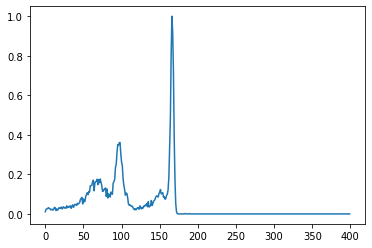

In [ ]:
plt.plot(x_eval_list[50].flatten())

## Estimate peak positions in ToT via fit

In [ ]:
import scipy.optimize
def normal(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))

def getPeakPositions(x, plot=False):
    bins = np.arange(len(x))
    thl = int(0.75 * len(x[x > 0]))

    # Left
    x_max = np.argmax(x[:thl])
    x_filt = x[x_max - 20: x_max + 20]
    x_filt /= np.max(x_filt)
    bins_filt =  bins[x_max - 20: x_max + 20]

    popt, pcov = scipy.optimize.curve_fit(normal, bins_filt, x_filt, p0=(bins[x_max], 30))
    peakLeft = popt[0]
    if plot:
        plt.plot(bins_filt, x_filt)
        plt.plot(bins_filt, normal(bins_filt, *popt))

    # Right
    x_max = np.argmax(x[thl:])
    x_filt = x[thl + x_max - 20: thl + x_max + 20]
    x_filt /= np.max(x_filt)
    bins_filt = bins[thl + x_max - 20: thl + x_max + 20]

    popt, pcov = scipy.optimize.curve_fit(normal, bins_filt, x_filt, p0=(bins[thl:][0] + bins[x_max], 30))
    peakRight = popt[0]
    if plot:
        plt.plot(bins_filt, x_filt)
        plt.plot(bins_filt, normal(bins_filt, *popt))
    return peakLeft, peakRight

  1%|          | 227/40000 [00:00<01:31, 435.20it/s]/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
  9%|▉         | 3615/40000 [00:08<01:22, 440.08it/s]/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 10%|█         | 4191/40000 [00:09<01:19, 447.85it/s]/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 14%|█▍        | 5716/40000 [00:12<01:12, 473.17it/s]/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 17%|█▋        | 6908/40000 [00:15<01:10, 470.94it/s]/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808

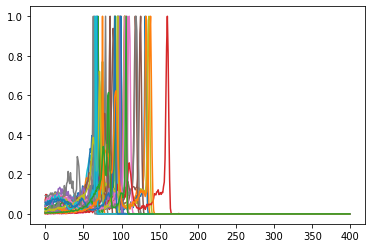

In [ ]:
peaksTrain = []
idx_fail = []
for idx, x in enumerate( tqdm.tqdm(x_train) ):
    try:
        peaksTrain.append( getPeakPositions(x.flatten()) )
    except:
        plt.plot(x.flatten())
        idx_fail.append( idx )
        peaksTrain.append( [0, 0] )
peaksTrain = np.asarray(peaksTrain)
idx_fail = np.asarray( idx_fail )

# Remove failed events from data
x_train = np.delete(x_train, idx_fail, axis=0)
y_train = np.delete(y_train, idx_fail, axis=0)
peaksTrain = np.delete(peaksTrain, idx_fail, axis=0)

  2%|▏         | 84/5000 [00:00<00:11, 427.93it/s]/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
  8%|▊         | 410/5000 [00:00<00:10, 452.48it/s]/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 31%|███       | 1557/5000 [00:03<00:07, 453.95it/s]/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 44%|████▍     | 2190/5000 [00:04<00:05, 468.99it/s]/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 58%|█████▊    | 2879/5000 [00:06<00:04, 470.81it/s]/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: Optim

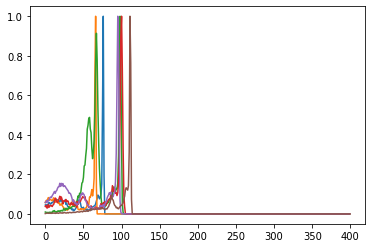

In [ ]:
peaksEval = []
idx_fail = []
for idx, x in enumerate( tqdm.tqdm(x_eval) ):
    try:
        peaksEval.append( getPeakPositions(x.flatten()) )
    except:
        plt.plot(x.flatten())
        idx_fail.append( idx )
        peaksEval.append( [0, 0] )
peaksEval = np.asarray(peaksEval)
idx_fail = np.asarray( idx_fail )

# Remove failed events from data
x_eval = np.delete(x_eval, idx_fail, axis=0)
y_eval = np.delete(y_eval, idx_fail, axis=0)
peaksEval = np.delete(peaksEval, idx_fail, axis=0)

In [ ]:
np.max(y_train * p_norm, axis=0)

array([  1.99999045,  99.99983685, -50.01062057,   9.99993065])

In [ ]:
train_filt = (y_train * p_norm)[:,0] > .01 # & ((y_train * p_norm)[:,1] > 100)
eval_filt = (y_eval * p_norm)[:,0] > .01 # & ((y_eval * p_norm)[:,1] > 100)

x_train = x_train[train_filt]
y_train = y_train[train_filt]
x_eval = x_eval[eval_filt]
y_eval = y_eval[eval_filt]
peaksTrain = peaksTrain[train_filt]
peaksEval = peaksEval[eval_filt]

[ 63.84810382 148.96120739]


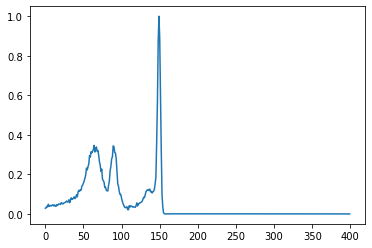

In [ ]:
idx = np.random.randint(1000)
plt.plot(x_train[idx])
print(peaksTrain[idx])

In [ ]:
x_train.shape, y_train.shape, peaksTrain.shape

((11993, 400, 1), (11993, 4), (11993, 2))

## Load JSON

In [ ]:
dataset = {'x': [], 'y': [], 'p': []}
for fn in os.listdir(directory):
    if not fn.endswith('.json'):
        continue
    
    with open(directory + fn, 'rb') as f:
        d = json.load(f)

    dataset['y'] += d['y']
    dataset['p'] += d['p']
    dataset['x'] = d['x'][-1]

In [ ]:
percentage = int(0.8 * len(dataset['y']))

x = np.asarray(dataset['x'])
dataset_train = {key: np.nan_to_num(np.asarray(dataset[key][:percentage])) for key in ['y', 'p']}
dataset_train['x'] = x

dataset_eval = {key: np.nan_to_num(np.asarray(dataset[key][percentage:])) for key in ['y', 'p']}
dataset_eval['x'] = x

In [ ]:
x, y = dataset_eval['x'], dataset_eval['y'][np.random.randint(0, len(dataset_eval['y']))]
x = x[y > 0]
y = y[y > 0]
plt.plot(x, y)
plt.grid()
plt.xlabel('Deposited energy (keV)')
plt.ylabel('Normalized counts')
plt.show()

## Load Measurements

In [ ]:
measurement = hck.load(directory + 'measurements/GeMo/Board1_FINAL/ToTMeasurement_169.hck')
measurement = np.asarray( [m / np.max(m) for m in np.asarray(measurement['Slot1'])[:,range(400)]] )
measurement = measurement.reshape((len(measurement), -1, 1))

In [ ]:
measurement = np.nan_to_num( json.load(open(directory + 'AmTHL/ToTMeasurement_AmTHL0.json', 'rb')) )
measurement = np.asarray( [m / np.max(m) for m in np.asarray(measurement)] )
measurement = measurement.reshape((len(measurement), -1, 1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


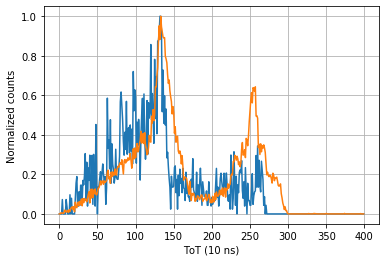

In [ ]:
y_small, y_large = np.zeros(400), np.zeros(400)
for pixel in range(16):
    if (pixel % 16) in [0, 1, 14, 15]:
        y_small += np.asarray(measurement[pixel]).flatten()
    else:
        y_large += np.asarray(measurement[pixel]).flatten()
plt.plot(y_small / np.max(y_small))
plt.plot(y_large / np.max(y_large))
plt.xlabel('ToT (10 ns)')
plt.ylabel('Normalized counts')
plt.grid()
plt.show()

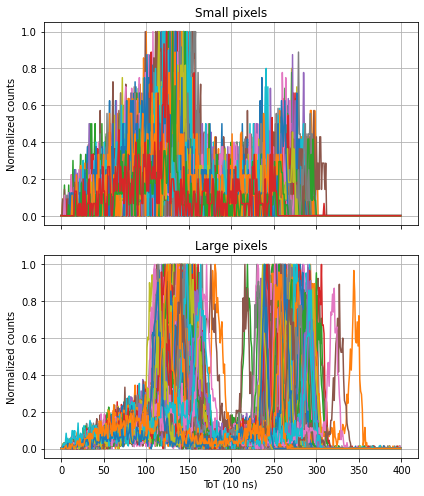

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(6, 7), sharex=True)
for pixel in range(256):
    if pixel % 16 in [0, 1, 14, 15]:
        ax[0].plot(measurement[pixel].flatten())
    else:
        ax[1].plot(measurement[pixel].flatten())
for a in ax:
    a.grid()
    a.set_ylabel('Normalized counts')
ax[1].set_xlabel('ToT (10 ns)')
ax[0].set_title('Small pixels')
ax[1].set_title('Large pixels')
plt.tight_layout()

In [ ]:
# Dataset normalization
p_norm = np.mean(dataset['p'], axis=0) # np.asarray( [2.6, -1.4, -90., -11.5])
def normalize_dataset(dataset, p_norm):
    x = np.nan_to_num(np.array(dataset['y'] / np.nanmax(dataset['y'], axis=0), copy=True).reshape((len(dataset['y']), -1, 1)))
    y = np.array(dataset['p'], copy=True)
    y /= p_norm
    return x, y

x_train, y_train = normalize_dataset(dataset_train, p_norm)
x_eval, y_eval = normalize_dataset(dataset_eval, p_norm)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6), sharex=True, sharey=True)
ax = ax.flatten()
titles=['a', 'b', 'c', 't']
for idx in range(4):
    ax[idx].hist(y_eval[:,idx], bins=30)
    ax[idx].set_title(titles[idx])
    ax[idx].grid()

In [ ]:
from keras.layers import Layer
# from keras.legacy import interfaces

class GaussianConvolutionNoise(Layer):
    def __init__(self, stddev, **kwargs):
        super(GaussianConvolutionNoise, self).__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs, training=None):
        def noised():
            input_noise = inputs * (1 + K.random_normal(K.shape(inputs), stddev=np.random.uniform(0, self.stddev)))
            input_noise = K.switch(K.equal(inputs, 0.), K.zeros_like(inputs), input_noise)
            out = K.clip(input_noise, 0, 1 + 3 * self.stddev)
            return out
        return K.in_train_phase(noised, inputs, training=training)

    def get_config(self):
        config = super().get_config()
        config['stddev'] = self.stddev
        return config

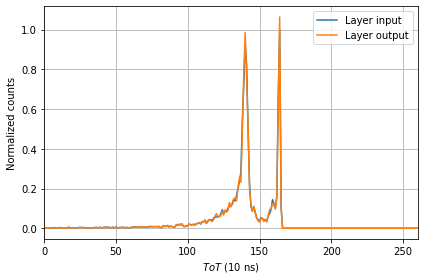

In [ ]:
idx = 80
x = GaussianConvolutionNoise(.5)(K.constant(x_eval[idx]), training=True)
plt.plot(x_eval[idx], label='Layer input')
plt.plot(K.eval(x), label='Layer output')
plt.xlabel(r'$ToT$ (10 ns)')
plt.ylabel('Normalized counts')
plt.legend()
plt.grid()
plt.tight_layout()
plt.xlim(0, 260)

plt.savefig('gaussian_conv_noise.pdf')

In [ ]:
activation = 'relu'
filter_size = 16
output_size = 4
kernel_size = 5

# Inputs
input_img = Input(shape=(400, 1))
input_peak = Input(shape=(2,))

# Convolution
# x = GaussianNoise(.15)(input_img)
x = GaussianConvolutionNoise(.3)(input_img)
x = Conv1D(filter_size, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = Conv1D(filter_size, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = Conv1D(filter_size, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = AveragePooling1D(pool_size=2, strides=2, padding='valid')(x)
x = Conv1D(filter_size << 1, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = Conv1D(filter_size << 1, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = Conv1D(filter_size << 1, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = AveragePooling1D(pool_size=2, strides=2, padding='valid')(x)
x = Conv1D(filter_size << 2, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = Conv1D(filter_size << 2, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = Conv1D(filter_size << 2, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = AveragePooling1D(pool_size=2, strides=2, padding='valid')(x)
x = Conv1D(filter_size << 3, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = Conv1D(filter_size << 3, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = Conv1D(filter_size << 3, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = AveragePooling1D(pool_size=2, strides=2, padding='valid')(x)

# Flatten
x = Flatten()(x)

# Dense & Dropout
x = Dense(output_size * 256, activation=activation)(x)
x = Dropout(rate=0.2)(x)
x = Dense(output_size * 128, activation=activation)(x)
x = Dropout(rate=0.2)(x)
x = Dense(output_size * 64, activation=activation)(x)
x = Dropout(rate=0.2)(x)
x = Dense(output_size, activation='linear')(x)

# Create model
regressor = Model((input_img, input_peak), x)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
confDict = regressor.get_config()

In [ ]:
regressor.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 400, 1)            0         
_________________________________________________________________
gaussian_convolution_noise_3 (None, 400, 1)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 400, 16)           96        
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 400, 16)           1296      
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 400, 16)           1296      
_________________________________________________________________
average_pooling1d_5 (Average (None, 200, 16)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 200, 32)           2592

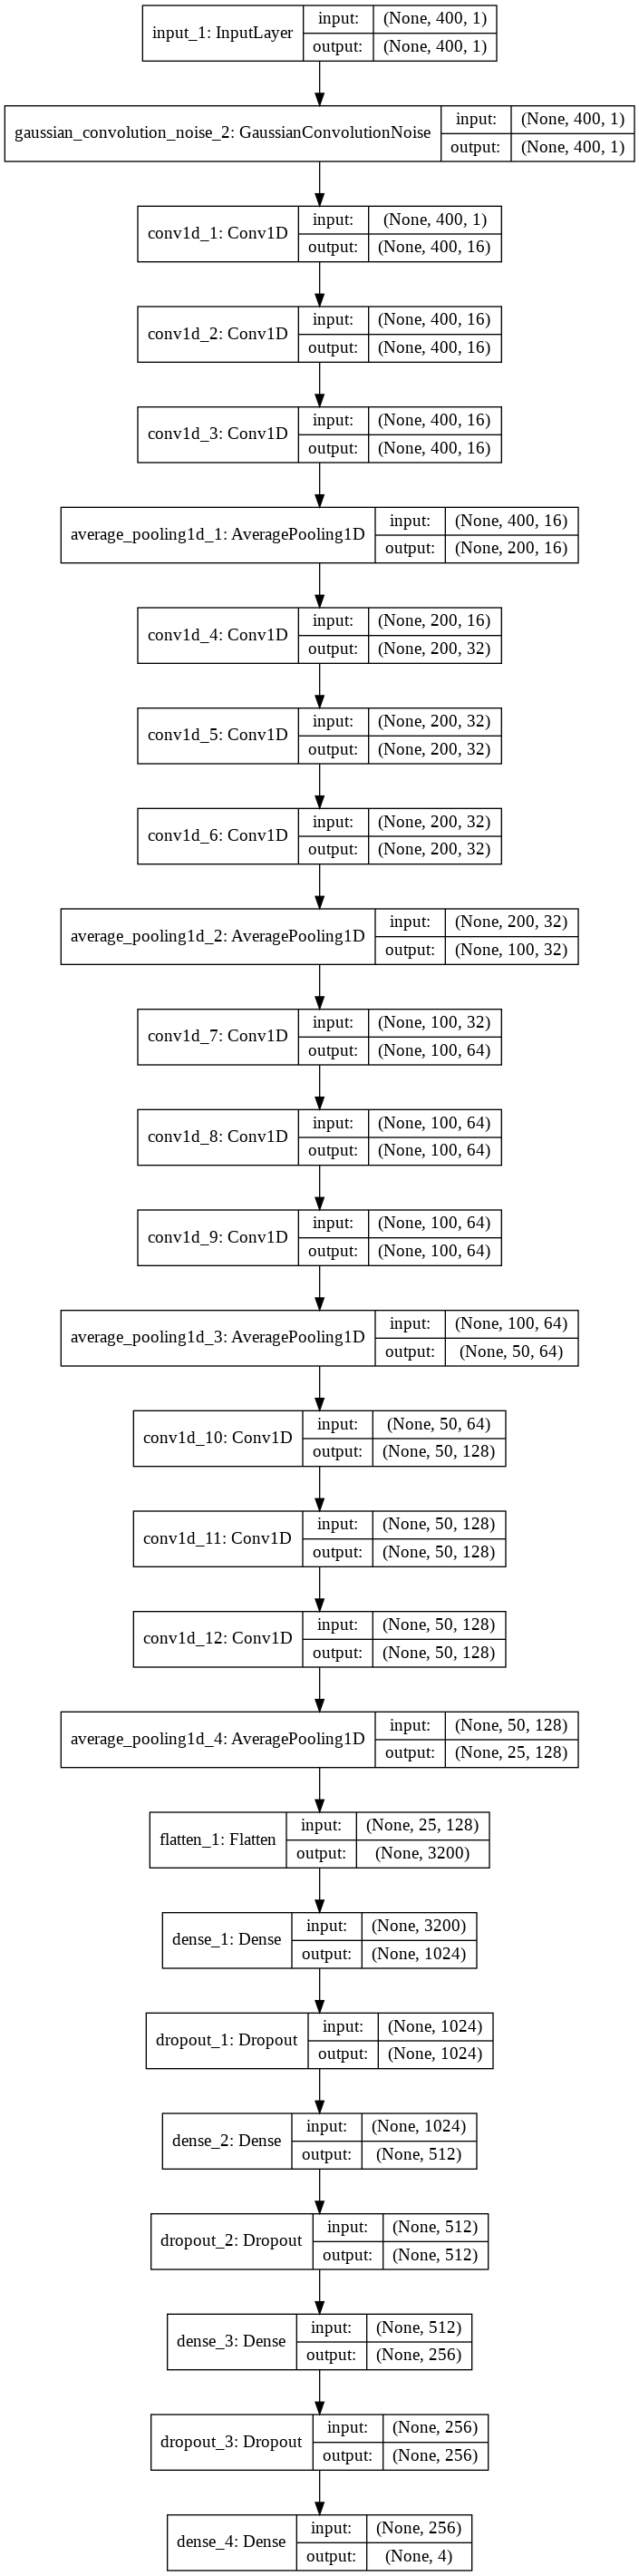

In [ ]:
PLOT_DIR = directory
plot_model(regressor, show_shapes=True, show_layer_names=True, to_file=PLOT_DIR + 'model.png')
Image(retina=False, filename=PLOT_DIR + 'model.png')

In [ ]:
adam = Adam(lr=0.0002)

def energyToToTInt(x, a, b, c, t):
    # Calculate integral
    return .5 * (a * x * (x - 2 * b) - 2 * c * t * K.log(K.abs(x - b)) - np.pi * c * x)

def ToTtoEnergySimple_keras(x, a, b, c, t):
    if SIMPLE:
        return b + 1./(4 * a) * (2*x + np.pi*c + K.sqrt(16 * a * c * t + (2 * x + np.pi * c)**2))
        # return 1./(4 * a) * (2*x + np.pi*c + 2*a*b + K.sqrt(16*a*c*t + (2*x + np.pi*c)**2 - 4*a*b*(np.pi*c - a*b + 2*x)))
    else:
        return 1./(2*a) * ( t*a + x - b + K.sqrt((b + t*a - x)**2 - 4*a*c) )

def getTHL_K(a, b, c, t):
    return (4*a*b + K.sqrt(K.abs(c * (16 * a * t + np.pi**2 * c))) + np.pi * c) / (4 * a)

def calibrationCurveLoss(yTrue, yPred):
    a, b, c, t = [yTrue[:, idx] for idx in range(4)]
    intTrue = energyToToTInt(60, a, b, c, t) - energyToToTInt(getTHL_K(a, b, c, t), a, b, c, t)

    a_, b_, c_, t_ = [yPred[:, idx] for idx in range(4)]
    intPred = energyToToTInt(60, a_, b_, c_, t_) - energyToToTInt(getTHL_K(a_, b_, c_, t_), a_, b_, c_, t_)

    paramLoss = K.sqrt(K.sum(K.square(yTrue - yPred))) 
    curveLoss = K.sqrt(K.sum(K.square(intTrue - intPred)))
    return paramLoss + curveLoss

def peakPositionLoss(peakPositions):
    def loss(yTrue, yPred):
        # mse_loss = K.mean(K.abs(yPred - yTrue), axis=-1)
        mse_loss = K.mean(K.square(yPred - yTrue), axis=-1)
        # peak_loss = ToTtoEnergySimple(peakPositions)

        a, b, c, t = [yPred[:, idx] for idx in range(4)]
        a *= p_norm[0]
        b *= p_norm[1]
        c *= p_norm[2]
        t *= p_norm[3]

        peak1, peak2 = peakPositions[:,0], peakPositions[:,1]
        energy1 = ToTtoEnergySimple_keras(peak1, a, b, c, t)
        energy2 = ToTtoEnergySimple_keras(peak2, a, b, c, t)

        peak_loss = K.mean(K.sqrt(K.square(energy1 - 17.17) + K.square(energy2 - 59.18)), axis=-1)
        return mse_loss + peak_loss / 5.
    return loss

# loss = 'mse'
loss = peakPositionLoss(input_peak)
regressor.compile(optimizer=adam, loss=loss, metrics=['mae', 'acc'])

In [ ]:
ToTtoEnergySimple(100, 1.8, -1.7, -55., -12.5)

56.940027984470134

In [ ]:
p1 = K.constant([[2.5, -1.6, -91., -14.5], [1.8, -1.7, -55., -12.5]])
p2 = K.constant([[1.8, -1.7, -55., -12.5], [1.8, -1.7, -55., -12.5]])
peaks = K.constant([[100, 100], [200, 200]])
loss = peakPositionLoss(peaks)(p1, p2)
K.eval(loss)

array([339.2748  ,  14.149811], dtype=float32)

## Standard Training

In [ ]:
history = regressor.fit([x_train, peaksTrain], y_train,
                epochs=100,
                batch_size=1024,
                shuffle=True,
                validation_data=([x_eval, peaksEval], y_eval))

Train on 39967 samples, validate on 4994 samples
Epoch 1/100
39967/39967 [==============================] - 7s 183us/step - loss: 0.8010 - mae: 0.2210 - acc: 0.5103 - val_loss: 0.7079 - val_mae: 0.2126 - val_acc: 0.5272
Epoch 2/100
39967/39967 [==============================] - 7s 179us/step - loss: 0.7983 - mae: 0.2205 - acc: 0.5108 - val_loss: 0.7030 - val_mae: 0.2109 - val_acc: 0.5326
Epoch 3/100
39967/39967 [==============================] - 7s 180us/step - loss: 0.7979 - mae: 0.2202 - acc: 0.5143 - val_loss: 0.7002 - val_mae: 0.2143 - val_acc: 0.5274
Epoch 4/100
39967/39967 [==============================] - 7s 179us/step - loss: 0.7963 - mae: 0.2212 - acc: 0.5100 - val_loss: 0.7103 - val_mae: 0.2128 - val_acc: 0.5308
Epoch 5/100
39967/39967 [==============================] - 7s 179us/step - loss: 0.8001 - mae: 0.2212 - acc: 0.5101 - val_loss: 0.7017 - val_mae: 0.2148 - val_acc: 0.5242
Epoch 6/100
39967/39967 [==============================] - 7s 180us/step - loss: 0.7952 - mae: 0

In [ ]:
from keras.models import load_model

# reg = load_model(directory + 'DNN_wPeakFit_newCalibFunc.h5', custom_objects={'GaussianConvolutionNoise': GaussianConvolutionNoise, 'loss': loss})
# reg = load_model(directory + 'DNNCalib_flori.h5', custom_objects={'GaussianConvolutionNoise': GaussianConvolutionNoise, 'loss': loss})
# regressor = Model(input=[reg.input, input_peak], output=reg.output)
# regressor.compile(optimizer=adam, loss=loss, metrics=['mae', 'acc'])

regressor.save(directory + 'DNNCalib_flori_2.h5')

## Loss Plot

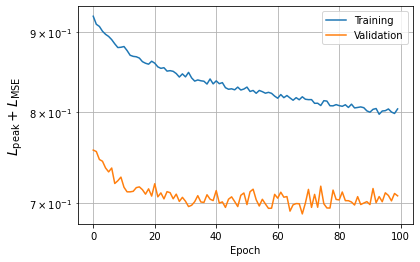

Text(0, 0.5, 'Accuracy')

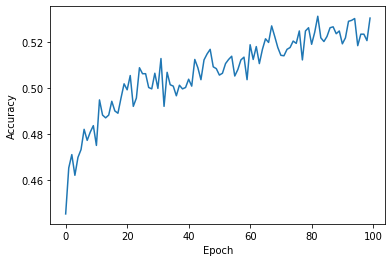

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.semilogy(history.history['val_loss'])
# plt.title('Model loss')
plt.ylabel('$L_\mathrm{peak} + L_\mathrm{MSE}$', fontsize=14)
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.grid(which='both')
plt.savefig('loss.pdf', bbox_inches='tight')
plt.show()

plt.plot(history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.savefig(PLOT_DIR + 'accuracy.svg')

## Calibration Function Evaluation

ValueError: ignored

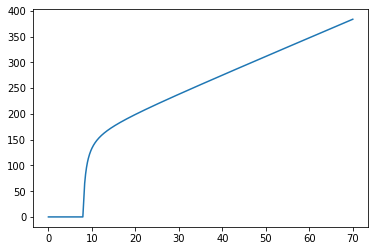

In [ ]:
x = np.linspace(0, 70, 1000)
idx = np.random.randint(0, len(y_train))
# x_train, y_train = next(eval_gen)
plt.plot(x, energyToToTSimple(x, *(y_train[idx]*p_norm)))
plt.plot(x, energyToToTSimple(x, *(regressor.predict(x_train)[idx]*p_norm)))

## Parameter MC Agreement

### Training data

In [ ]:
a, b, c, t = regressor.predict([x_eval, np.zeros((len(x_eval), 2))]).T

c_ = 2. / np.pi * a * b + c
t_ = c * t / c_
c, t = c_, t_

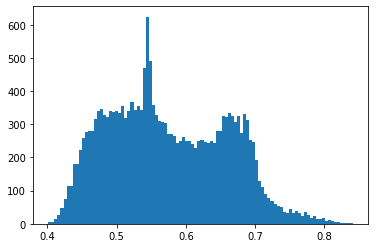

In [ ]:
plt.hist(t, bins=100);

1.004928178315406 0.8442796486116984 0.42327731921069495 0.29584732201462366
1.5896217568180524 1.6579535090528723 0.39724078447088923 0.6585290069070128
1.3294064758607105 1.3517514272943454 0.631217344172499 0.5767187899228015
1.1194455614141035 1.1217231746801188 0.2238900044608764 0.20913329406280975


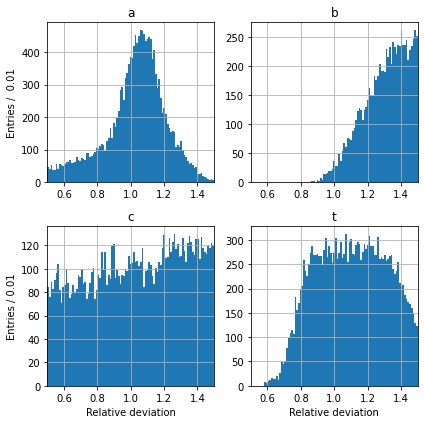

In [ ]:
def expFit(x, lam):
    return lam * np.exp(-lam * x)

fig, ax = plt.subplots(2, 2, figsize=(6, 6), sharex=False, sharey=False)
ax = ax.flatten()
titles=['a', 'b', 'c', 't']
bins = np.linspace(0.5, 1.5, 100)
for idx in range(4):
    v = (y_eval / np.nan_to_num(regressor.predict([x_eval, np.zeros((len(x_eval), 2))])))[:,idx]
    # v = np.abs(v - np.median(v))
    v[np.abs(v - np.median(v)) > 10] = 0
    # ax[idx].set_yscale('log')
    h, b, s = ax[idx].hist(v, bins=bins, density=False)
    # popt, pcov = scipy.optimize.curve_fit(expFit, b[:-1], h)
    # print(popt)
    # ax[idx].plot(b[:-1], expFit(b[:-1], *popt), ls='--', color='k')

    ax[idx].set_title(titles[idx])
    ax[idx].set_xlim(.5, 1.5)
    ax[idx].grid()
    print(np.median(v), np.mean(v), np.std(v), np.mean(np.abs(v - 1)))

# axis labels
ax[2].set_xlabel('Relative deviation')
ax[0].set_ylabel('Entries /  %.2f' % np.diff(bins)[0])
ax[3].set_xlabel('Relative deviation')
ax[2].set_ylabel('Entries / %.2f' % np.diff(bins)[0])
plt.tight_layout()
plt.savefig('dnn_calib_params.pdf')

## Evaluation data

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6), sharex=True, sharey=False)
ax = ax.flatten()
titles=['a', 'b', 'c', 't']
bins = np.linspace(0.5, 1.5, 100)
for idx in range(4):
    ax[idx].hist((y_eval / regressor.predict(x_eval))[:,idx], bins=bins)
    ax[idx].set_title(titles[idx])
    ax[idx].grid()
plt.tight_layout()

## Training Evaluation

In [ ]:
def convert_prediction(p):
    a, b, c, t = p
    c_ = 2. / np.pi * a * b + c
    t_ = c * t / c_
    c, t = c_, t_
    p = np.dstack([a, b, c, t])[0]
    return p

In [ ]:
print( convert_prediction([0.5, 5, -80, -2.5]) )
print( convert_prediction([5.5, 12, -30, -1]) )

[[  0.5          5.         -78.40845057  -2.55074547]]
[[ 5.5        12.         12.01690498  2.49648308]]


In [ ]:
# p_norm = np.asarray( [3.6, 2., -30., -0.1])
# p_norm = np.asarray( [3.6, 2., -30., -0.1])
# p_norm = [2.5, 8.5, -55, -1.75]
# p_norm = [1.85, 125.0, -275.0, 7.5]

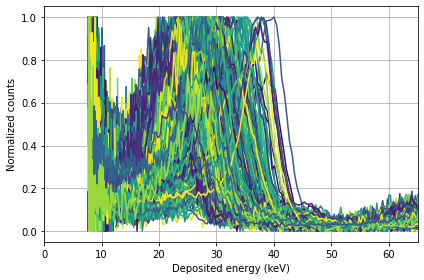

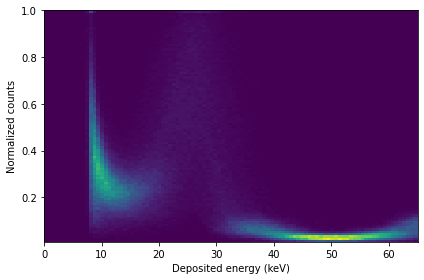

In [ ]:
# x_eval = next(eval_gen)[0]
p_predict = regressor.predict([x_eval, np.asarray(peaksEval)])
x = np.arange(400)
p = p_predict * p_norm

N = 1024
color = [getColor('viridis', N, idx) for idx in range(N)]
np.random.shuffle(color)

x_total, y_total = [], []
N_cnt = 0
idx = 0
while N_cnt < N:
    if (y_eval * p_norm)[:,0][idx] < 2:
        idx += 1
        continue
    x_ = ToTtoEnergySimple(x, *p[idx])
    y_ = x_eval[idx].flatten()[:-1] / np.diff(x_)

    x_total.append(x_[:-1]), y_total.append(y_ / np.max(y_))
    plt.plot(x_[:-1], y_ / np.max(y_), color=color[N_cnt])
    N_cnt += 1
    idx += 1

plt.xlim(0, 65)
plt.xlabel('Deposited energy (keV)')
plt.ylabel('Normalized counts')
plt.grid()
plt.tight_layout()
plt.savefig('spectra_eval.pdf')
plt.show()

# Density plot
plt.hist2d(np.asarray(x_total).flatten(), np.asarray(y_total).flatten(), bins=(np.linspace(0, 65, 100), np.linspace(0.01, 1., 100)));
plt.xlabel('Deposited energy (keV)')
plt.ylabel('Normalized counts')
plt.tight_layout()
plt.savefig('spectra_eval_hist.pdf')
plt.show()

(0.0, 70.0)

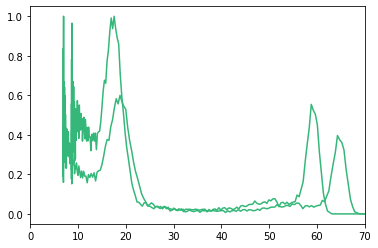

In [ ]:
idx = 100

p_sigma = np.asarray([0.056756166338514366, 0.18422534435762314, 0.08689540431038473, 0.3598264253205084])
x_ = ToTtoEnergySimple(x, *p[idx])
y_ = x_eval[idx].flatten()[:-1] / np.diff(x_)
plt.plot(x_[:-1], y_ / np.max(y_), color=color[idx])

x_ = ToTtoEnergySimple(x, *(p[idx] * (1 - p_sigma)))
y_ = x_eval[idx].flatten()[:-1] / np.diff(x_)
plt.plot(x_[:-1], y_ / np.max(y_), color=color[idx])

plt.xlim(0, 70)

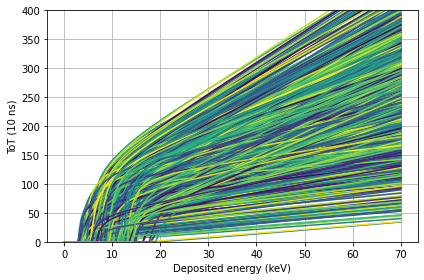

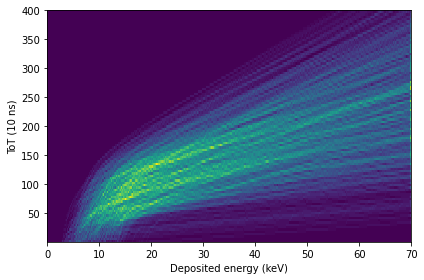

In [ ]:
x = np.linspace(0, 70, 1000)
# p_predict = regressor.predict(x_eval)
p = p_predict * p_norm

x_total, y_total = [], []
for idx in range(N):
    y = energyToToTSimple(x, *p[idx])
    x_total.append(x), y_total.append(y)
    plt.plot(x, y, color=color[idx])
plt.ylim(0, 400)
plt.xlabel('Deposited energy (keV)')
plt.ylabel('ToT (10 ns)')
plt.grid()
plt.tight_layout()
plt.savefig('calib_eval.pdf')
plt.show()

# Density plot
plt.hist2d(np.asarray(x_total).flatten(), np.asarray(y_total).flatten(), bins=(x, np.linspace(0.1, 400, 100)));
plt.xlabel('Deposited energy (keV)')
plt.ylabel('ToT (10 ns)')
plt.tight_layout()
plt.savefig('calib_eval_hist.pdf')
plt.show()

## Measurement Evaluation

In [ ]:
def predictMeasurement(measurement, plot=True):
    import scipy.interpolate
    p_predict = regressor.predict([measurement, np.zeros((len(measurement), 2))])
    p = p_predict * p_norm
    x = np.arange(400)

    color = [getColor('viridis', 16, idx) for idx in range(16)]
    np.random.shuffle(color)

    x_new = np.linspace(0, 80, 3000)
    y_total = np.zeros(len(x_new))
    THL = getTHL(*p.T)
    for idx in range(16):
        if idx % 16 in [0, 1, 14, 15]:
            continue

        x_ = ToTtoEnergySimple(x, *p[idx])
        f = scipy.interpolate.interp1d(x_[:-1], 
                  measurement[idx].flatten()[:-1] / np.diff(x_), bounds_error=False, fill_value=0)
        y = f(x_new) 
        y_total += np.nan_to_num(y / np.max(y))
        if plot:
            # plt.plot(ToTtoEnergySimple(x, *p[idx]), measurement[idx].flatten())
            plt.plot(x_new, y / np.max(y), color=color[idx])

    if plot:
        plt.xlim(0, 75)
        plt.grid()
        plt.xlabel('Deposited energy (keV)')
        plt.ylabel('Normalized counts')
        plt.tight_layout()
        plt.savefig('DNNCalib_output.pdf')
        plt.show()

    # THL distribution
    h, b, p_ = plt.hist(THL, bins=30)
    print(np.mean(THL), np.std(THL))
    if plot:
        plt.axvline(x=np.mean(THL), color='k')
        plt.axvline(x=np.median(THL), ls='-.', color='k')
        plt.axvline(x=np.mean(THL) + np.std(THL), ls='--', color='k')
        plt.axvline(x=np.mean(THL) - np.std(THL), ls='--', color='k')
        plt.xlabel(r'Threshold energy $E_\mathrm{THL}$ (keV)')
        plt.ylabel('Number of pixels / %.2f keV' % np.diff(b)[0])
        plt.grid()
        plt.tight_layout()
        plt.savefig('DNNCalib_THL_hist.pdf')
        plt.show()

    # Sum over all large pixels 
    if plot:
        plt.xlim(0, 75)
        plt.plot(x_new, y_total / np.max(y_total))
        plt.grid()
        plt.xlabel('Deposited energy (keV)')
        plt.ylabel('Normalized counts')
        plt.tight_layout()
        plt.savefig('DNNCalib_mean_hist.pdf')
        plt.show()

    return y_total / np.max(y_total), p, np.mean( THL ), np.std( THL )

def plotMeasurementPrediction(thl_range, mean_thl_list, std_thl_list, y_total_list, p_mean_list, name='THLshift'):
    if name == 'Ikrum':
        name = r'$I_\mathrm{krum}$'

    plt.errorbar(thl_range, mean_thl_list, yerr=std_thl_list, marker='x', capsize=5)
    plt.grid()
    plt.xlabel('%s (DAC)' % name)
    plt.ylabel(r'Threshold energy $E_\mathrm{THL}$ (keV)')
    plt.tight_layout()
    plt.savefig('DNNCalib_%s_energy.pdf' % name)
    plt.show()

    fig, ax = plt.subplots()
    axCBar = fig.add_axes([.92, 0.1, 0.05, 0.8])

    for idx, y_total in enumerate(y_total_list):
        color = getColor('viridis', len(y_total_list), idx)
        ax.plot(np.linspace(0, 80, 3000), y_total, color=color)
    getColorBar(axCBar, cbMin=thl_range[0], cbMax=thl_range[-1], N=len(thl_range), 
                   label='%s (DAC)' % name, rotation=0, use_float=False)

    ax.set_xlim(0, 65)
    ax.grid()
    ax.set_xlabel('Deposited energy (keV)')
    ax.set_ylabel('Normalized counts')
    fig.savefig('DNNCalib_%s_hist.pdf' % name, bbox_inches='tight')
    plt.show()

    x = np.linspace(0, 70, 1000)
    fig, ax = plt.subplots()
    axCBar = fig.add_axes([.92, 0.1, 0.05, 0.8])

    for idx, p in enumerate(p_mean_list):
        color = getColor('viridis', len(y_total_list), idx)
        ax.plot(x, energyToToTSimple(x, *p), color=color)
    getColorBar(axCBar, cbMin=thl_range[0], cbMax=thl_range[-1], N=len(thl_range), 
                   label='%s (DAC)' % name, rotation=0, use_float=False)

    ax.grid()
    ax.set_xlabel('Deposited energy (keV)')
    ax.set_ylabel('ToT (10 ns)')
    fig.savefig('DNNCalib_%s_calib_curves.pdf' % name, bbox_inches='tight')
    plt.show()

def getColorBar(ax, cbMin, cbMax, N=20, label=None, rotation=90, use_float=False):
    # Plot colorbar
    import matplotlib as mpl
    from matplotlib.colors import ListedColormap
    cmap = mpl.cm.get_cmap('viridis', N)
    norm = mpl.colors.Normalize(vmin=cbMin, vmax=cbMax)
    cBar = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')

    # cBar.ax.invert_yaxis()
    cBar.formatter.set_powerlimits((0, 0))
    cBar.ax.yaxis.set_offset_position('right')
    cBar.update_ticks()

    labels = np.linspace(cbMin, cbMax, N + 1)
    locLabels = np.linspace(cbMin, cbMax, N)
    loc = labels + abs(labels[1] - labels[0])*.5
    cBar.set_ticks(loc)
    if use_float:
        cBar.ax.set_yticklabels(['%.1f' % loc for loc in locLabels], rotation=rotation, verticalalignment='center')
    else:
        cBar.ax.set_yticklabels(['%d' % loc for loc in locLabels], rotation=rotation, verticalalignment='center')
    cBar.outline.set_visible(False)
    cBar.set_label(label)

### Calibration Measurements

In [ ]:
# Is data already binned?
make_hist = False
# Ikrum = 12
# measurement = np.nan_to_num( json.load(open(directory + 'measurements/Ikrum_calibration_det22/ToTMeasurement_22_None_None_Ikrum%d.json' % Ikrum, 'rb')) )

Ikrum = 30
measurement = np.nan_to_num( json.load(open(directory + 'measurements/params_%s_Ikrum%d_hist.json' % ('prag', Ikrum), 'rb')) )
histDict = {}
for slot in measurement.keys():
    if slot == 'bins':
        continue
    print(slot)
    hist = []
    for pixel in range(256):
        # if pixel % 16 in [0, 1, 14, 15]:
        #     continue
        if make_hist:
            h, b = np.histogram(np.asarray(measurement[slot]).T[pixel], bins=np.arange(1, 402))
        else:
            h = np.asarray( measurement[slot][pixel] )
            b = np.arange(len(h))

        h = np.asarray(h, dtype=float)
        h /= float(np.max(h))
        hist.append( np.nan_to_num(h) )
    histDict[int(slot[-1])] = hist

2


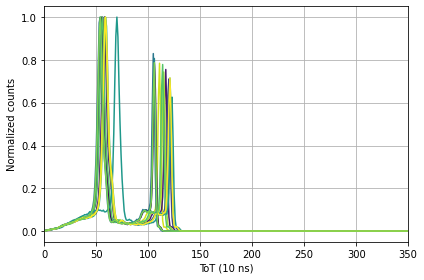

In [ ]:
color = getColor('viridis', 16, np.arange(16))
np.random.shuffle(color)

for pixel in range(16):
    if pixel % 16 in [0, 1, 14, 15]:
        continue
    plt.plot(np.asarray(histDict[2])[pixel], color=color[pixel])

plt.ylabel('Normalized counts')
plt.xlabel('ToT (10 ns)')
plt.xlim(0, 350)
plt.grid()
plt.tight_layout()
plt.savefig('DNNCalib_input.pdf')

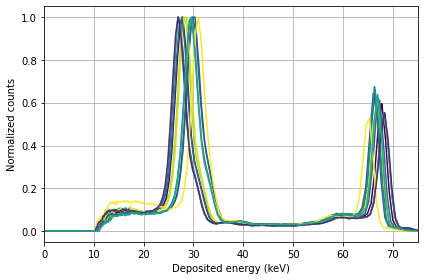

11.07674680163492 0.6844469282353418


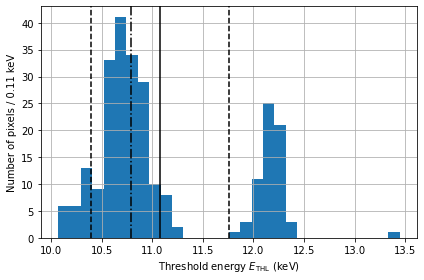

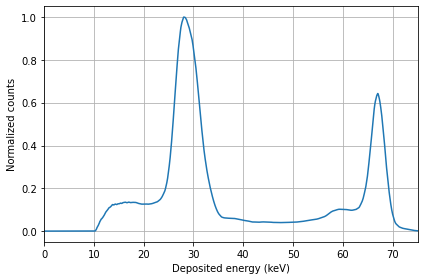

In [ ]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

paramsDict = {}
titles = [None, 99, None]
for key in histDict.keys():
    if titles[int(key) - 1] is None:
        continue

    m = histDict[key]
    m = np.asarray(m).reshape((len(m), -1, 1))
    paramsDict[key] = regressor.predict([m, np.zeros((len(m), 2))]) * p_norm
    predictMeasurement(m)

    a, b, c, t = paramsDict[key].T
    outDict = {pixel: {'a': a[pixel], 'b': b[pixel], 'c': c[pixel], 't': t[pixel]} for pixel in range(256)}
    #with open(directory + 'measurements/params_%d_Ikrum%d.json' % (titles[int(key) - 1], Ikrum), 'w') as f:
    #     json.dump(outDict, f, cls=NumpyEncoder)

In [ ]:
x = x_eval[30].flatten()
x_n = np.random.normal(x, 0.02)
x_n[x == 0] = 0
x_n[x_n < 0] = 0
plt.plot(x_n)

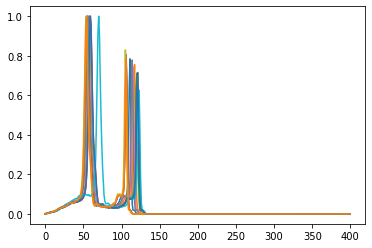

In [ ]:
for h in histDict[2][2:14]:
  plt.plot(h)

### THL Variation

In [ ]:
largePixels = np.asarray( [False if pixel % 16 in [0, 1, 14, 15]  else True for pixel in range(256)] )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


8.368921085452156 0.641102629785047
8.638686597315676 0.6624988197061695
8.912283384161038 0.8526519741471693
9.262334472098235 0.9677795036700426
9.885161281443112 1.0936971271508178
10.47677933064906 1.155979382100503
11.063260665601577 1.0614868237258759
11.506709052585686 0.9722256971634893
11.977626155918612 0.8429082335750306
12.331799521831476 0.9224976449077952
12.557804814557292 0.8340438411061873


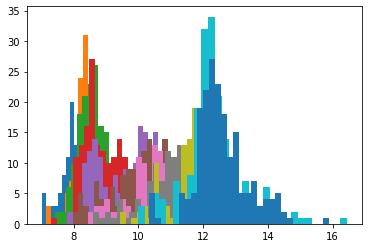

In [ ]:
y_total_list, mean_thl_list, std_thl_list = [], [], []
p_mean_list, p_std_list = [], []
thl_range = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
for thl in thl_range:
    measurement = np.nan_to_num( json.load(open(directory + 'AmTHL/ToTMeasurement_AmTHL%d.json' % thl                                                                                                                                , 'rb')) )
    measurement = np.asarray( [m / np.max(m) for m in np.asarray(measurement)] )
    measurement = measurement.reshape((len(measurement), -1, 1))[largePixels]

    y_total, p, mean_thl, std_thl = predictMeasurement(measurement, plot=False)
    p_mean_list.append( np.mean(p, axis=0) )
    p_std_list.append( np.std(p, axis=0) )
    y_total_list.append( y_total )
    mean_thl_list.append( mean_thl )
    std_thl_list.append( std_thl )

a 2.761141461630663 3.0438295238030477
b 62.2957133455202 104.58426891515653
c -232.9936504441624 -154.34227434452623
t 7.148065676447004 10.218810341320932


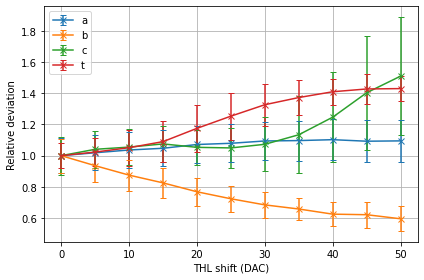

In [ ]:
titles = ['a', 'b', 'c', 't']

for idx in range(4):
    y = np.asarray(p_mean_list).T[idx]
    y_err = np.asarray(p_std_list).T[idx]
    print(titles[idx], min(y), max(y))
    plt.errorbar(thl_range, y / y[0], yerr=y_err / y[0], marker='x', label=titles[idx], capsize=3)
plt.legend()
plt.grid()
plt.xlabel("THL shift (DAC)")
plt.ylabel('Relative deviation')
plt.tight_layout()
plt.savefig('DNNCalib_THLshift_params.pdf')

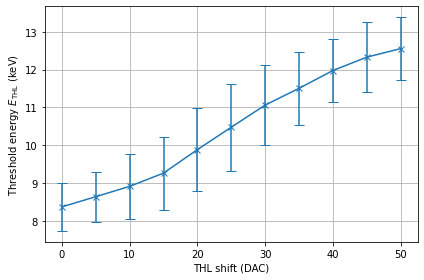

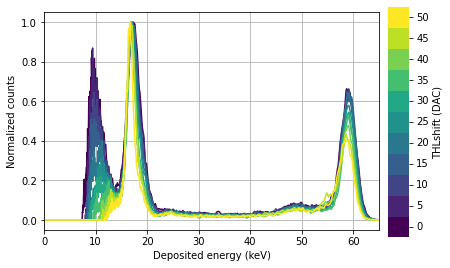

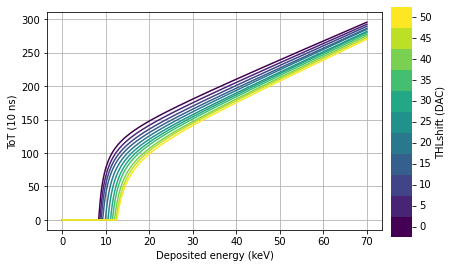

In [ ]:
# New prediction
plotMeasurementPrediction(thl_range, mean_thl_list, std_thl_list, y_total_list, p_mean_list)

In [ ]:
# Old prediction
plotMeasurementPrediction(thl_range, median_thl_list, y_total_list, p_mean_list)

### Ikrum Variation

10
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


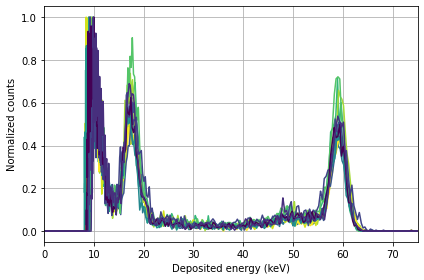

8.822985051835943 0.6961131802884284


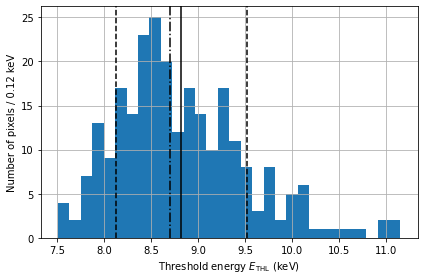

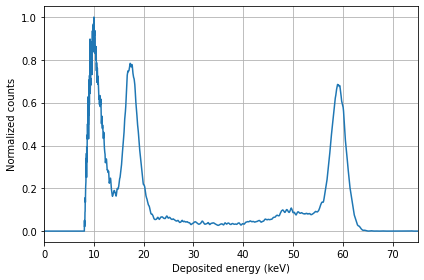

12
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


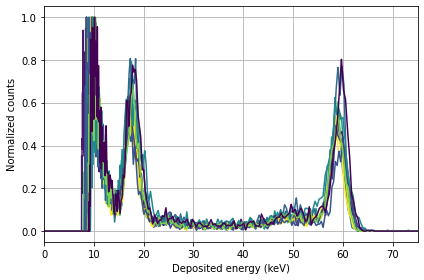

8.736651468222323 0.7626173291835903


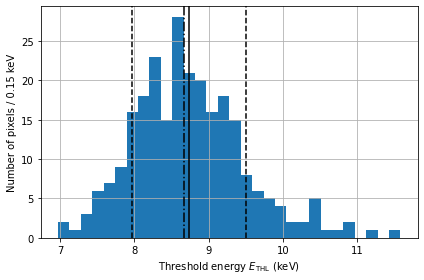

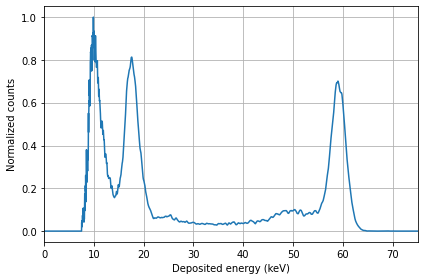

14
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


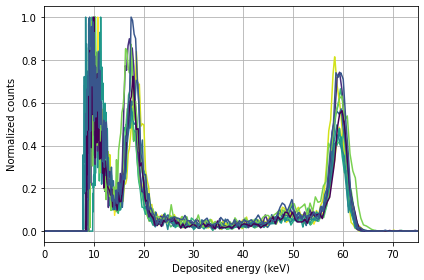

8.702485582332416 0.7835375871820516


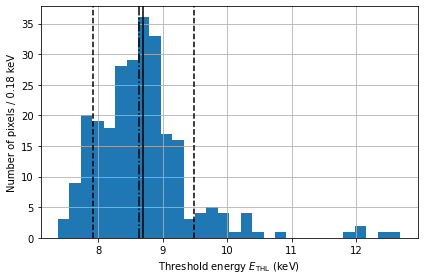

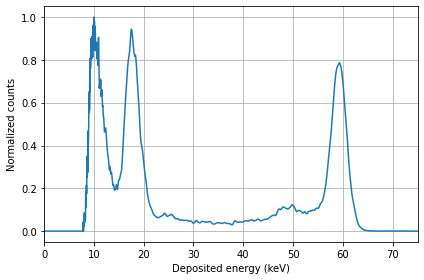

16
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


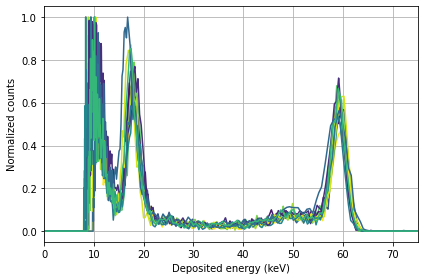

8.758055831599844 0.6580018574910896


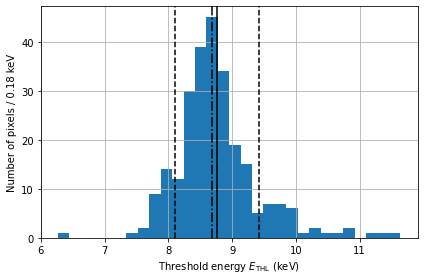

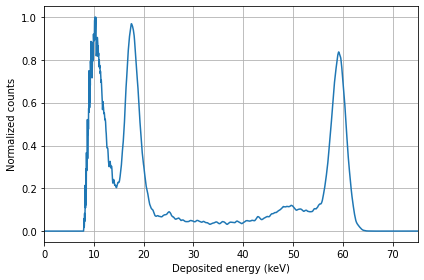

18
[[0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


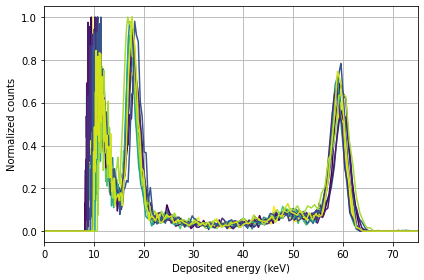

9.242586546151227 1.0364263826112887


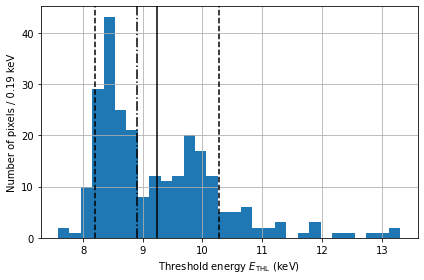

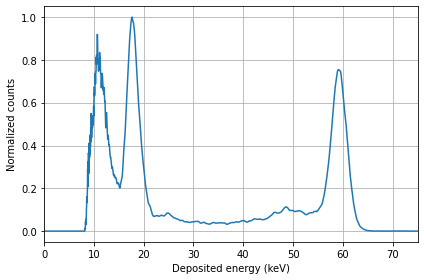

20
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


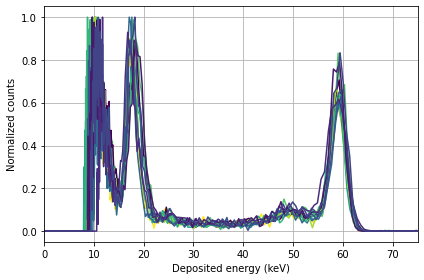

9.380978513310462 1.1225293427002225


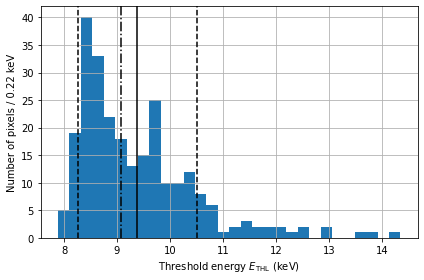

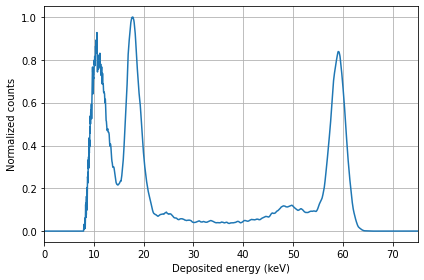

22
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


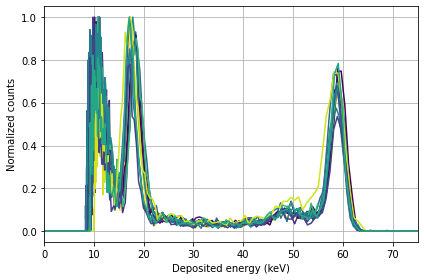

9.463493256757511 1.1839836877293641


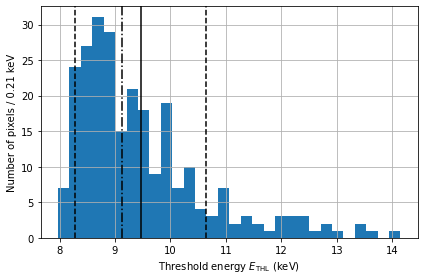

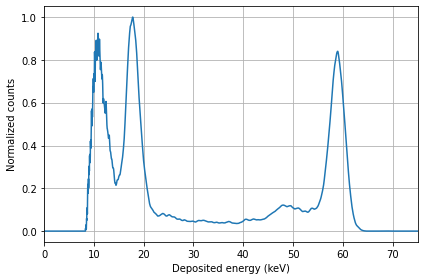

24
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 2. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


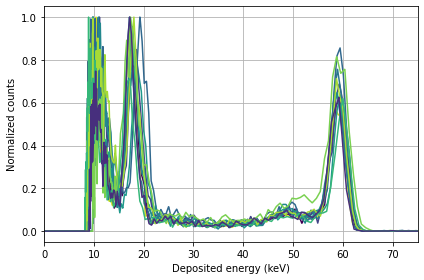

9.378927514196839 1.1713797597740956


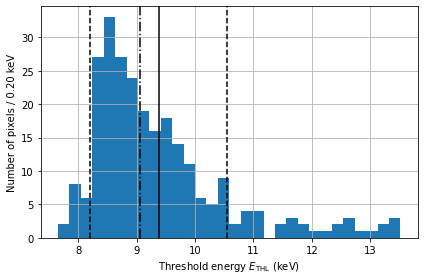

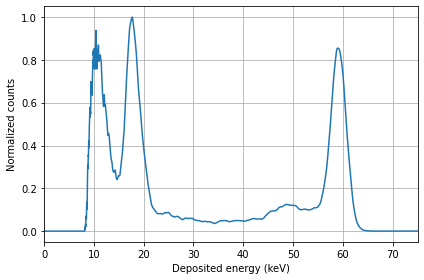

26
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


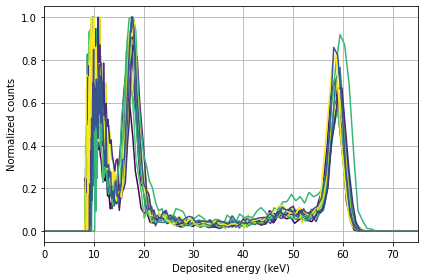

9.322464870199711 1.1792968287363617


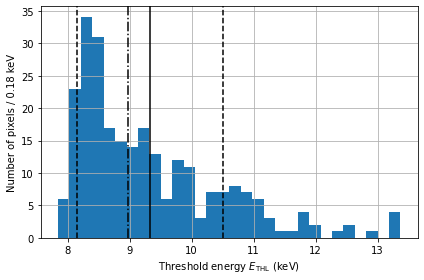

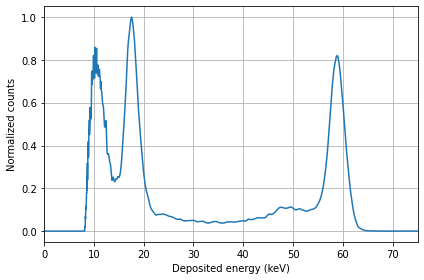

28
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 3. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


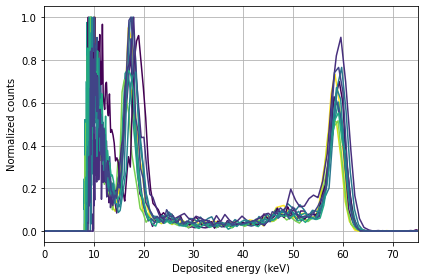

9.258029876637341 1.112156618250938


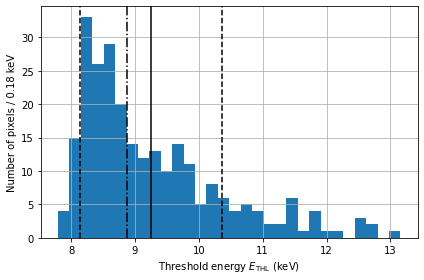

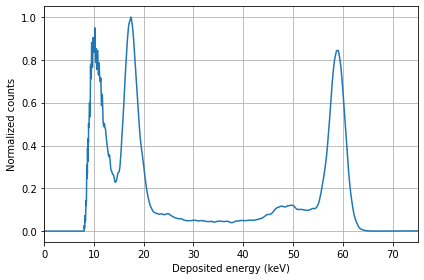

30
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 2. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


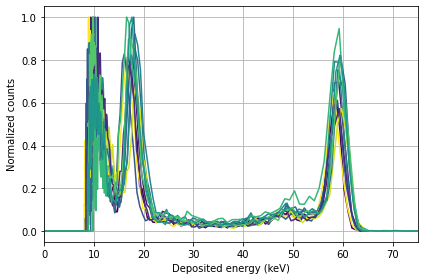

9.136104673810959 0.9633226659133857


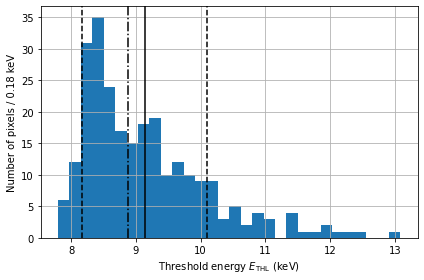

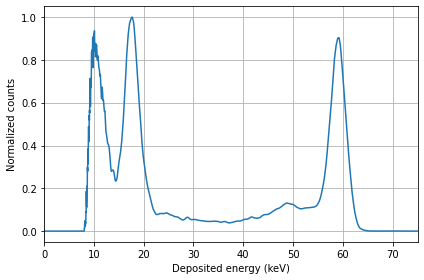

32
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


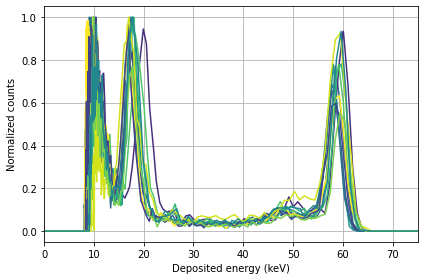

9.116528546378122 0.9075854309105068


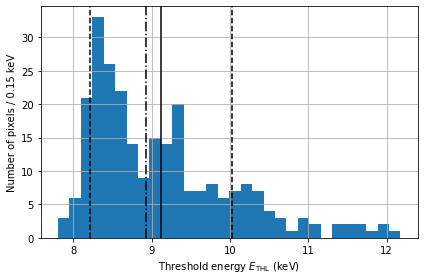

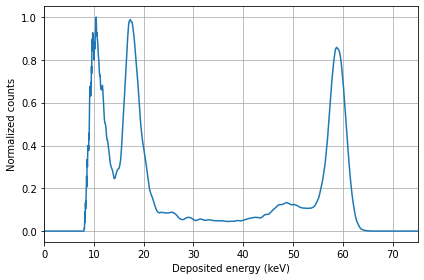

34
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 5. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


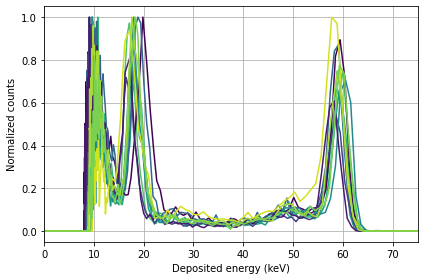

9.043858722169954 0.8643452489755727


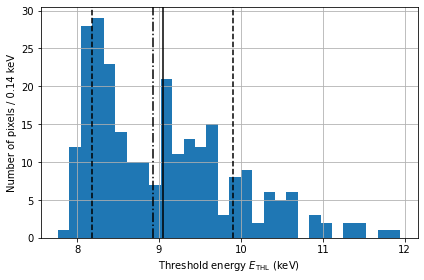

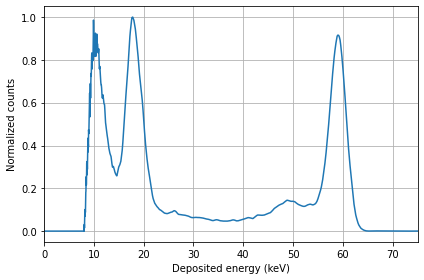

36
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


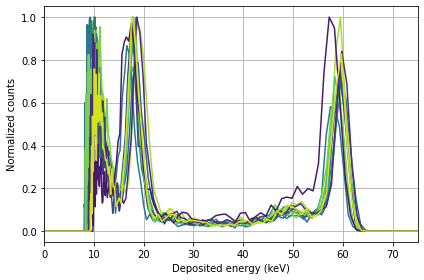

9.063325557332002 0.8746728518194262


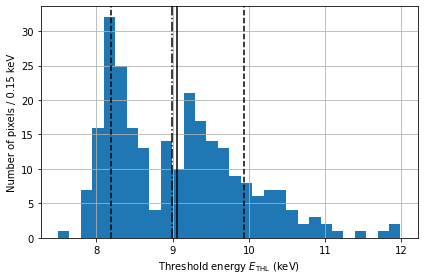

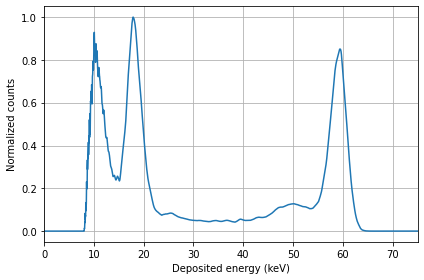

38
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 2. 1. ... 0. 0. 0.]
 ...
 [0. 3. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


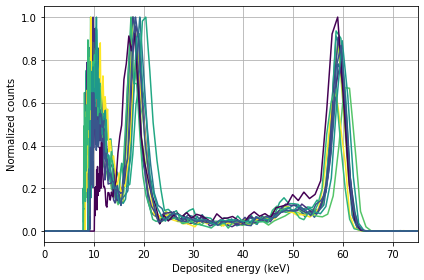

8.955919179472382 0.7695883945032164


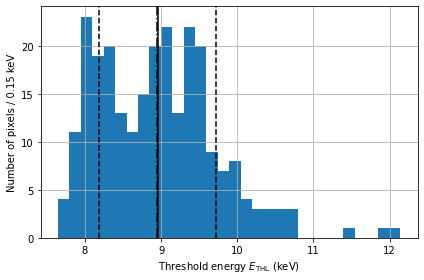

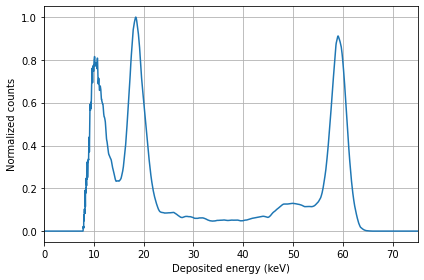

40
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 3. ... 0. 0. 0.]
 ...
 [0. 1. 6. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


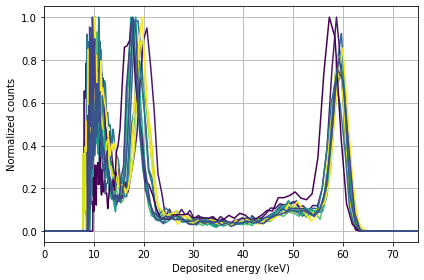

8.970828628682522 0.7412046195118949


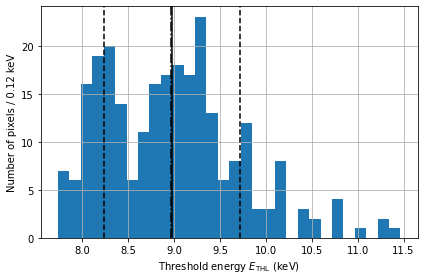

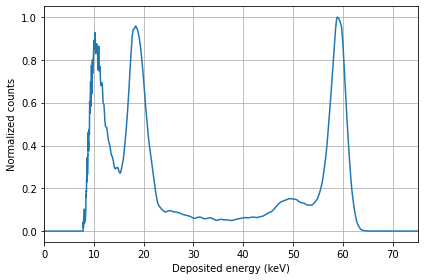

42
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


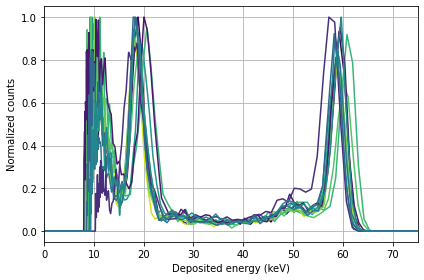

8.963988493845498 0.7014249064047597


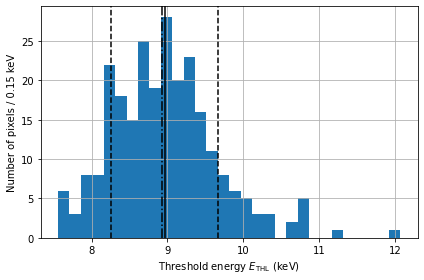

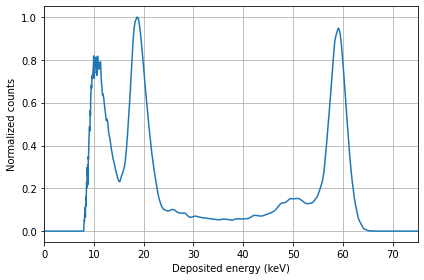

44
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 2. 2. ... 0. 0. 0.]
 ...
 [0. 2. 4. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


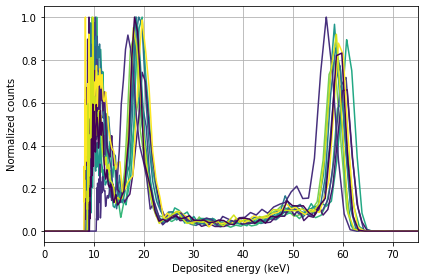

8.954514950847152 0.5941710034556926


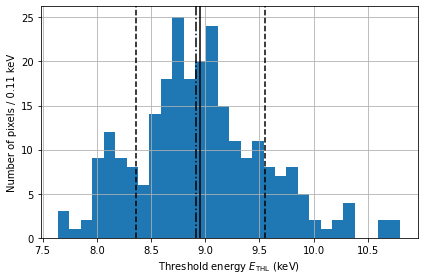

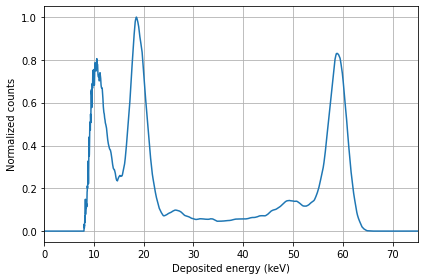

46
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 3. 3. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 2. ... 0. 0. 0.]]


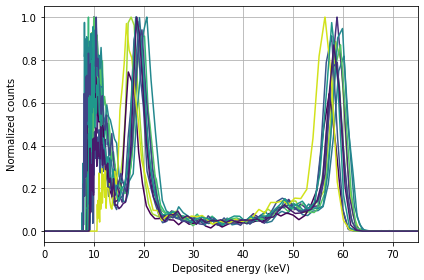

8.963457086508779 0.604582423505054


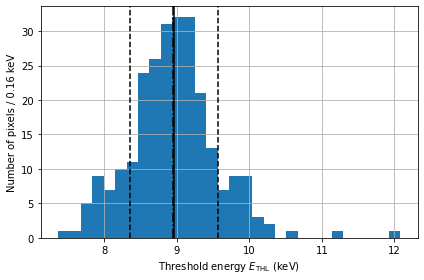

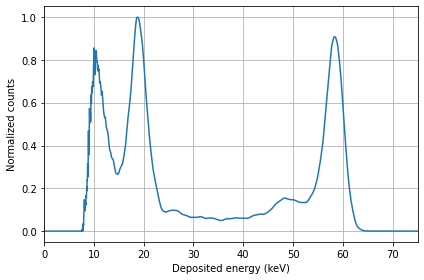

48
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 2. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


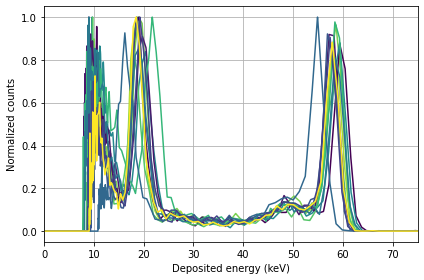

8.981940328452291 0.5633196449576202


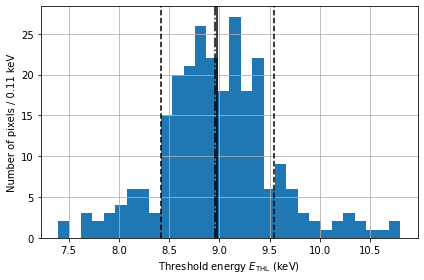

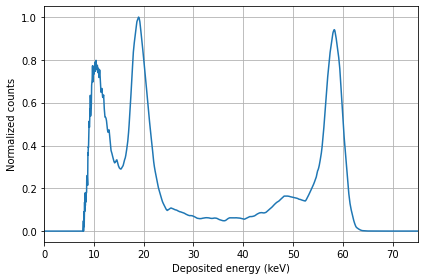

50
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 3. 2. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 2. 0. ... 0. 0. 0.]]


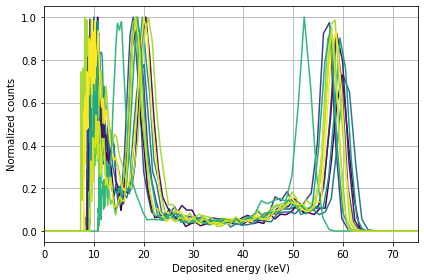

9.017433620135845 0.5296682443139121


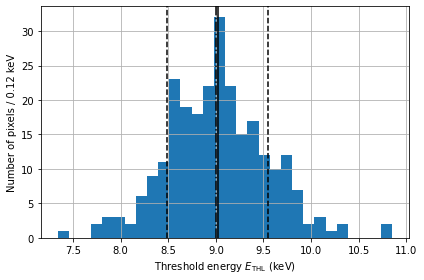

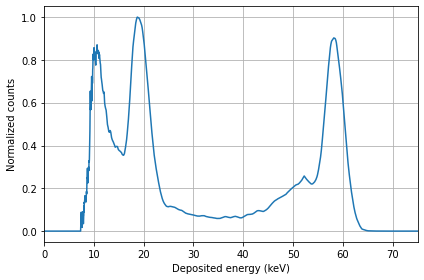

In [ ]:
y_total_list, median_thl_list = [], []
std_thl_list = []
p_mean_list, p_std_list = [], []
# Ikrum_range = [10, 15, 20, 25, 30, 35, 40, 45, 50]
Ikrum_range = np.arange(10, 50 + 2, 2)
for Ikrum in Ikrum_range:
    # measurement = np.nan_to_num( json.load(open(directory + 'AmIkrum/ToTMeasurement_AmIkrum%d.json' % Ikrum, 'rb')) )
    print(Ikrum)
    measurement = np.nan_to_num( json.load(open(directory + 'measurements/Ikrum_calibration_det22/ToTMeasurement_22_None_None_Ikrum%d.json' % Ikrum, 'rb'))['Slot1'] )
    print(measurement)

    measurement = np.asarray( [m / np.max(m) for m in np.asarray(measurement)] )
    measurement = measurement.reshape((len(measurement), -1, 1))

    y_total, p, median_thl, std_thl = predictMeasurement(measurement)
    p_mean_list.append( np.mean(p, axis=0) )
    p_std_list.append( np.std(p, axis=0) )
    y_total_list.append( y_total )
    median_thl_list.append( median_thl )
    std_thl_list.append( std_thl )

a 0.8355137760227072 2.846390377520583
b 46.21639137621969 106.29338514991105
c -157.88614485354628 -96.82085081294645
t 7.15983551053796 7.802945229923353


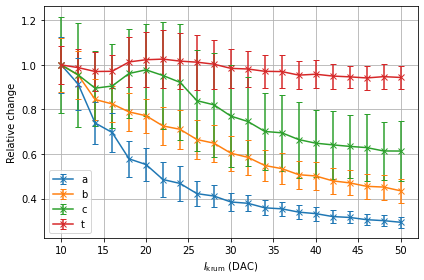

In [ ]:
for idx in range(4):
    y = np.asarray(p_mean_list).T[idx]
    y_err = np.asarray(p_std_list).T[idx]
    print(titles[idx], min(y), max(y))
    plt.errorbar(Ikrum_range, y / y[0], yerr=y_err/y[0], marker='x', label=titles[idx], capsize=3)
plt.legend()
plt.grid()
plt.xlabel(r"$I_\mathrm{krum}$ (DAC)")
plt.ylabel('Relative change')
plt.tight_layout()
plt.savefig('DNNCalib_Ikrum_params.pdf')

In [ ]:
json.dump({'Ikrum': Ikrum_range, 'params': p_mean_list}, open('Ikrum_calibration_det22.json', 'w'), cls=NumpyEncoder)

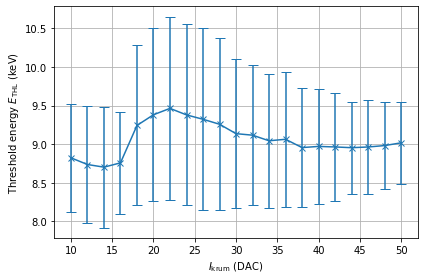

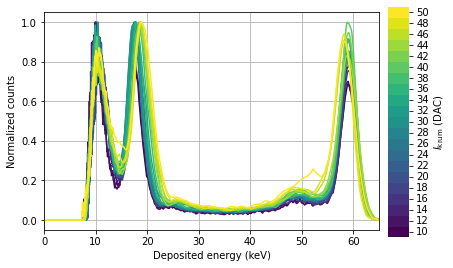

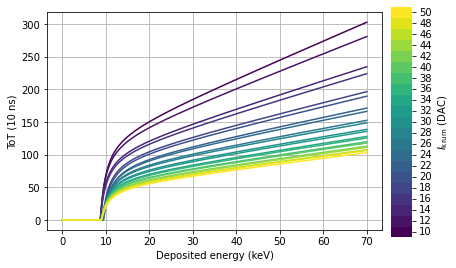

In [ ]:
plotMeasurementPrediction(Ikrum_range, median_thl_list, std_thl_list, y_total_list, p_mean_list, name='Ikrum')

### Single Calibration Curves

In [ ]:
measurement = np.nan_to_num( json.load(open(directory + 'AmIkrum/ToTMeasurement_AmIkrum20.json', 'rb')) )
measurement = np.asarray( [m / np.max(m) for m in np.asarray(measurement)] )
measurement = np.asarray(measurement).reshape((len(measurement), -1, 1))

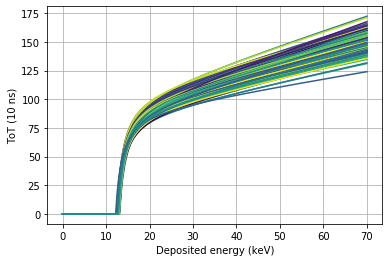

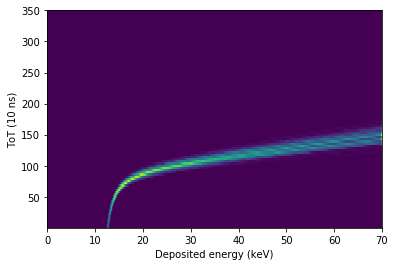

[  0.95520215  11.32999867 -60.38557494  -2.22425623]


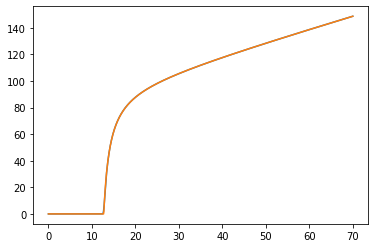

In [ ]:
x = np.linspace(0, 70, 1000)
p_predict = regressor.predict(measurement)
p = p_predict * p_norm

x_total, y_total = [], []
color = [getColor('viridis', 256, idx) for idx in range(256)]
np.random.shuffle(color)
for idx in range(256):
    if idx % 16 in [0, 1, 14, 15]:
        continue
    y = energyToToTSimple(x, *p[idx])
    plt.plot(x, y, color=color[idx])
    x_total.append( x ), y_total.append( y )
plt.grid()
plt.xlabel('Deposited energy (keV)')
plt.ylabel('ToT (10 ns)')
plt.show()

# Density plot
plt.hist2d(np.asarray(x_total).flatten(), np.asarray(y_total).flatten(), bins=(x, np.linspace(0.1, 350, 100)));
plt.xlabel('Deposited energy (keV)')
plt.ylabel('ToT (10 ns)')
plt.show()

# Mean curve
plt.plot(x, np.mean(y_total, axis=0))
import scipy.optimize
p0 = [2.64001481, 4.75595151, -79.80103223, -4.12532132]
popt, pcov = scipy.optimize.curve_fit(energyToToTSimple, x, np.mean(y_total, axis=0), p0=p0)
plt.plot(x, energyToToTSimple(x, *popt))
print(popt)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


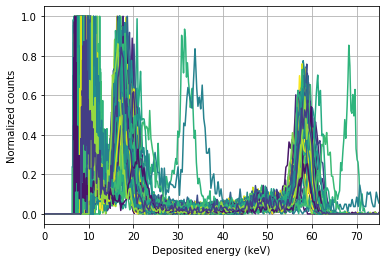

7.598627105312435


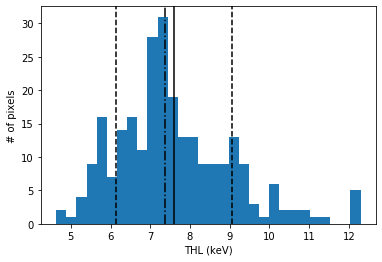

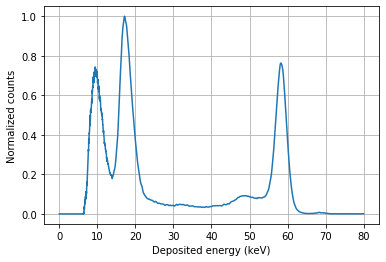

(array([0.        , 0.        , 0.        , ..., 0.00064853, 0.00065342,
        0.0006583 ]),
 array([[  2.49669209,   4.83251229, -68.07475805,  -1.41861339],
        [  1.68307349,   5.09832424, -73.44749093,  -1.6250495 ],
        [  2.60608077,   6.19630015, -77.07552314,  -1.7306475 ],
        ...,
        [  2.90874422,   6.93371594, -68.15984845,  -1.98064113],
        [  1.20094091,   5.54536366, -75.88785052,  -1.75880152],
        [  1.09896258,   5.31161034, -69.93821025,  -1.78081617]]),
 7.3805459820121655)

In [ ]:
measurement = np.nan_to_num( json.load(open(directory + 'AmTHL/ToTMeasurement_AmTHL%d.json' % 0                                                                                                                                , 'rb')) )
measurement = np.asarray( [m / np.max(m) for m in np.asarray(measurement)] )
measurement = measurement.reshape((len(measurement), -1, 1))

predictMeasurement(measurement)

In [ ]:
for idx in range(4):
    p = (p_predict * p_norm)[:,idx]
    plt.hist(p, bins=30)
    plt.show()

In [ ]:
x = np.linspace(0, 10, 1000)
a, b, c, t = p_norm
y = a*(x - b) - c * (np.pi / 2 + t / (x - b))
y[x < THL] = 0
plt.plot(x, y)
plt.plot(x, a*(x - b) - c * np.pi / 2, ls='--', color='k')

In [ ]:
x = np.linspace(getTHL_K(*p_norm), 15, 1000)
x = np.linspace(0, 300, 1000)
plt.plot(x, dev_(x, *p_norm) / np.max(dev_(x, *p_norm)))
plt.plot(x[:-1], np.diff(dev_(x, *p_norm)) / np.max(np.diff(dev_(x, *p_norm))))

In [ ]:
x = np.linspace(0, 175, 1000)
plt.plot(x, bg_model_wResolution(conv(x), 0.85, 11., 1.6, 0.23) * 1. / dev_(x, *p_norm))

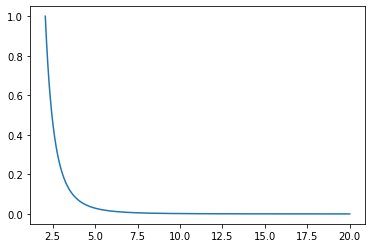

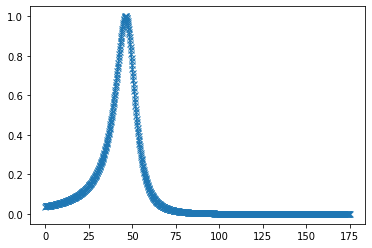

In [ ]:
def energyToToTSimple(x, a, b, c, t):
    res = np.where(x > getTHL_K(a, b, c, t), a*(x - b) - c * (np.pi / 2 + t / (x - b)), 0)
    return res

def ToTtoEnergySimple(x, a, b, c, t):
    return b + 1./(4 * a) * (2*x + np.pi*c + np.sqrt(16 * a * c * t + (2 * x + np.pi * c)**2))

def getTHL(a, b, c, t):
    return (4*a*b + np.sqrt(c * (16 * a * t + np.pi**2 * c)) + np.pi * c) / (4 * a)
    
def dev(x, a, b, c, t):
    return a + c * t / (x - b)**2

def dev_(x, a, b, c, t):
    return (0.25 * (2 + (2 * (c * np.pi + 2 * x))/np.sqrt(16 * a * c * t + (c * np.pi + 2 * x)**2)))/a

def getTHL_K(a, b, c, t):
    return (4*a*b + np.sqrt(np.abs(c * (16 * a * t + np.pi**2 * c))) + np.pi * c) / (4 * a)

p_norm = np.asarray( [3.6, 2., -30., -0.1])
THL = getTHL_K(*p_norm)

x = np.linspace(getTHL_K(*p_norm), 15, 1000)
x_ToT = energyToToTSimple(x, *p_norm)
# plt.plot(x_ToT, np.exp(-(x - THL) / 1.) * 1. / dev(x, *p_norm), marker='x')

# 1. / dev(ToTtoEnergySimple(x, *p_norm), *p_norm)
def ToTtoEnergyScale(x, a, b, c, t):
    return (np.sqrt(16 * a * c * t + (np.pi * c + 2 * x)**2) + np.pi * c + 2 * x) / (2 * a * np.sqrt(16 * a * c * t + (np.pi * c + 2 * x)**2))

def f(x, THL, beta, s, off):
    return np.where(x > THL, np.exp(-(x - s)**2 / beta), 0) + np.abs(off)
    # return np.where(x > THL, np.exp(-(x - THL) / beta), 0) + np.abs(off)

'''
def bg_model_woResolution(x, A, s, sig, m, t, off):
    compton = 0 # A * np.exp(-(x - s)**2 / (2 * sig**2))
    charge_sharing = np.exp(-m * x + t)
    return compton + charge_sharing + off
'''

def bg_model_woResolution(x, m, t, off):
    charge_sharing = np.exp(-(x - m) / t)
    return 1 / x**4 # np.full(len(x), 1) # charge_sharing + off

def bg_model_wResolution(x, A, s, sig, B):
    peak = A * np.exp(-(x - s)**2 / (2 * sig**2))
    bg = B * (0.5 * scipy.special.erf((x - s) / (np.sqrt(2) * sig)) + 0.5)
    return peak + bg

# def fitFunc(x, a, b, c, t, A, s, sig, m, t_exp, off):
# def fitFunc(x, a, b, c, t, A, s, sig, B):
def fitFunc(x, a, b, c, t, m, t_, off):
    p = [a, b, c, t]
    conv = lambda x: ToTtoEnergySimple(x, *p)
    THL = getTHL_K(*p)
    # y = f(conv(x), THL, beta, s, off) * ToTtoEnergyScale(x, *p)
    # y = np.where(conv(x) > THL, bg_model_wResolution(conv(x), A, s, sig, m, t_exp, off), 0) * ToTtoEnergyScale(x, *p)
    # y = np.where(conv(x) > THL, bg_model_wResolution(conv(x), A, s, sig, B), 0) * ToTtoEnergyScale(x, *p)
    y = np.where(conv(x) > THL, bg_model_woResolution(conv(x), m, t_, off), 0) * dev_(x, *p)
    return y / np.max(y)

# p0_woResolution = (821, 8, 2.6, 0.4, 9, 130)
p0_woResolution = (5, 2, .1)
p0_wResolution = (0.85, 11., 1.6, 0.23)

x = np.linspace(THL, 20, 1000)
y = bg_model_woResolution(x, *p0_woResolution)
plt.plot(x, y / np.max(y))
plt.show()

# x in ToT
x = np.linspace(0, 175, 1000)
conv = lambda x: ToTtoEnergySimple(x, *p_norm)

y = fitFunc(x, *np.append(p_norm, p0_woResolution)) # f(x, 10.) * ToTtoEnergyScale(x, *p_norm)
plt.plot(x, y, marker='x')

In [ ]:
fx = np.linspace(0, 20, 1000)
plt.semilogy(x, bg_model_wResolution(x, *p0_wResolution))
plt.grid(which='both')

In [ ]:
print(a)

In [ ]:
import scipy.optimize
import scipy.signal
def normal(x, A, mu, sig):
    return A * np.exp(-(x - mu)**2 / (2 * sig**2))

x_spec, y_spec = np.arange(400), scipy.signal.savgol_filter(measurement[10].flatten(), 11, 3)
popt, pcov = scipy.optimize.curve_fit(normal, x_spec[(x_spec > 120) & (x_spec < 170)], y_spec[(x_spec > 120) & (x_spec < 170)], p0=(1., 125, 20))

plt.plot(x_spec, y_spec)
plt.plot(x_spec, normal(x_spec, *popt))
plt.xlim(0, 310)

energies = [17., 59.8]
xToT = [135, 300]
a = (xToT[-1] - xToT[0]) / (energies[-1] - energies[0])
plt.show()
y_spec, x_spec = y_spec[x_spec < 120], x_spec[x_spec < 120]
# y_spec -= normal(x_spec, *popt)
y_spec[y_spec < 0] = 0

# p0 = [3., 2., -40., -0.2, 1060, 8, 2.6, 0.4, 9, 130]
# p0 = (7., 5., -30., -0.2, 0.85, 11., 1.6, 0.23)
p0 = (2., 5., -20., -0.9, 5, 2, .1)
def fit_wrapper(p, x, y, ToT, energy):
    bg_loss = np.sqrt(np.sum(np.square(y - fitFunc(x, *p))))
    energy_loss = np.sqrt(np.sum(np.square(energyToToTSimple(np.asarray(energy), *p[:4]) - np.asarray(ToT))))
    return bg_loss + energy_loss

res = scipy.optimize.minimize(fit_wrapper, x0=p0, args=(x_spec, y_spec / np.max(y_spec), xToT, energies), method='Nelder-Mead')
# print(res)
popt = res['x']

plt.plot(x_spec, y_spec / np.max(y_spec))
plt.plot(x_spec, fitFunc(x_spec, *p0))
plt.plot(x_spec, fitFunc(x_spec, *popt))

'''
popt, pcov = scipy.optimize.curve_fit(lambda x, b, c, t, A, s, sig, m, t_exp, off: fitFunc(x, a, b, c, t, A, s, sig, m, t_exp, off), x_spec, y_spec / np.max(y_spec), p0=p0)
popt = np.insert(popt, 0, a)
print(popt, np.sqrt(np.diag(pcov)))
'''

In [ ]:
p_norm = np.asarray( [3.6, 8., -70., -0.5] )
x_spec, y_spec = np.arange(400), scipy.signal.savgol_filter(measurement[22].flatten(), 11, 3)
y_spec, x_spec = y_spec[x_spec < 150], x_spec[x_spec < 150]
plt.plot(ToTtoEnergySimple(x_spec, *p_norm), y_spec / dev_(x_spec, *p_norm))
plt.grid()
plt.show()

plt.plot(x_spec, y_spec / np.max(y_spec))
plt.grid()
plt.show()

x = np.linspace(0, 30, 1000)
plt.plot(x, energyToToTSimple(x, *p_norm))
plt.grid()

In [ ]:
x = np.linspace(0, 70, 1000)
plt.plot(x, energyToToTSimple(x, *popt[:4]))
plt.grid()

In [ ]:
plt.plot(x, dev_(x, *p_norm))

In [ ]:
x_spec, y_spec = np.arange(400), measurement[10].flatten()
p = popt[:4]
plt.plot(ToTtoEnergySimple(x_spec, *p), y_spec * dev(ToTtoEnergySimple(x_spec, *p), *p))
plt.xlim(0, 65)

In [ ]:
plt.plot(x, ToTtoEnergyScale(x, *p_norm))

In [ ]:
hist = plt.hist(np.random.exponential(1, 10000) + THL, bins=300)
plt.show()

h = hist[0] # * 1. / np.diff(tps.energyToToTSimple(hist[1], *p_norm))
plt.plot(energyToToTSimple(hist[1][:-1], *p_norm), h / np.max(h), marker='x')
plt.show()

plt.plot(energyToToTSimple(hist[1][1:], *p_norm),
         1. / np.diff(energyToToTSimple(hist[1], *p_norm)), marker='x')
maximum = hist[1][np.argmax(hist[0])]
plt.axvline(x=maximum, ls='--', color='k')
plt.show()

d = energyToToTSimple(np.random.exponential(1, 10000) + THL, *p_norm)
d = d[d > 0]
hist = plt.hist(d, bins=100)

plt.axvline(x=maximum, ls='--', color='k')

In [ ]:
x = np.linspace(0, 10, 1000)
plt.axhline(y=maximum, ls='--', color='k')
plt.axvline(x=tps.ToTtoEnergySimple(maximum, *p_norm), ls='--', color='k')
plt.plot(x, tps.energyToToTSimple(x, *p_norm))
plt.show()

x = np.linspace(0, 10, 1000)
plt.plot(x[:-1], np.diff(tps.energyToToTSimple(x, *p_norm)))
plt.axvline(x=tps.ToTtoEnergySimple(maximum, *p_norm), ls='--', color='k')